# Assignment-1: Computational Genomics
## Task 1.1
A dataset "dataset.h5ad" has been provided, which contains a single-cell gene expression matrix. The following are the tasks to be performed on this dataset. 
1. Quality control, normalization, feature selection and PCA.
2. Following this, data is to be clustered using the Leiden Clustering Algorithm. 
3. Differential expression analysis is to be performed upon each cluster to identify the marker genes.  
4. Based on the marker genes identified, the clusters obtained are to be annotated. 

Note - the dataset can be accessed from the following link: [Large-Files](https://drive.google.com/drive/folders/1e78HYxcL1Z_czrz-b37Mc8F3HIk6b6th?usp=sharing). Let us begin this task by importing the required packages. 

### Loading the Dataset

In [1]:
import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
matrix = sc.read('C:/Personal/Academics/IITK Resources/Sem-7/Computational-Genomics/Large-Files/dataset.h5ad')
matrix

AnnData object with n_obs × n_vars = 10727 × 12303

What does this output mean? 
- n_obs refers to the number of cells. Hence, here we have 10,727 cells. 
- n_vars refers to the number of genes. This matrix contains details about 12,303 genes. 

Inspecting the AnnData object. 

In [3]:
matrix.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '12293', '12294', '12295', '12296', '12297', '12298', '12299', '12300',
       '12301', '12302'],
      dtype='object', length=12303)

In [4]:
matrix.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '10717', '10718', '10719', '10720', '10721', '10722', '10723', '10724',
       '10725', '10726'],
      dtype='object', length=10727)

Adding the gene IDs provided.

In [5]:
gene_IDs = pd.read_csv('gene_names.csv')
gene_IDs

,0
0,LINC00115
1,FAM41C
2,SAMD11
3,NOC2L
4,KLHL17
...,...
12298,YBEY
12299,PCNT
12300,DIP2A
12301,S100B


In [6]:
matrix.var_names = gene_IDs['0'].values
matrix.var_names

Index(['LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4',
       'ISG15', 'AGRN', 'TTLL10',
       ...
       'COL6A2', 'FTCD', 'LSS', 'MCM3AP-AS1', 'MCM3AP', 'YBEY', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', length=12303)

### Quality Control
Finding the mitochondrial, ribosomal and hemoglobin genes. 

In [7]:
# mitochondrial genes
matrix.var["mt"] = matrix.var_names.str.startswith("MT-")
# ribosomal genes
matrix.var["ribo"] = matrix.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
matrix.var["hb"] = matrix.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    matrix, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

The function above, adds the qc metrics to our AnnData object. The log1p=True returns the logarithm of the results (log(1+x)), which accounts for skewed distrubutions. 

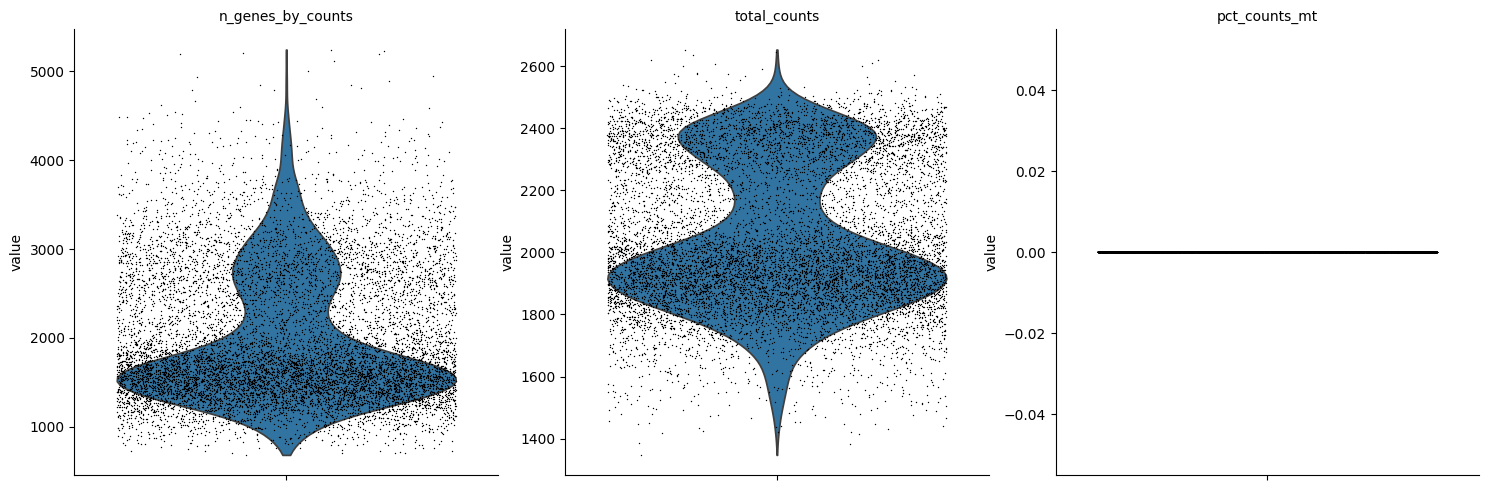

In [8]:
sc.pl.violin(
    matrix,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

It is clear from the above violin plots that there are no mitochondrial genes expressed. 

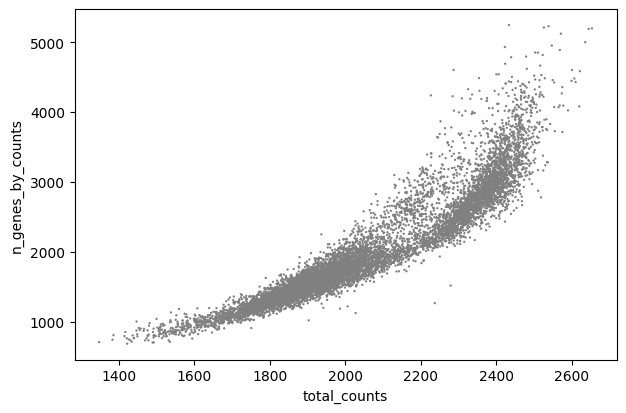

In [9]:
sc.pl.scatter(matrix, "total_counts", "n_genes_by_counts")

To choose apt quality control thresholds, it may be helpful to draw histograms. 

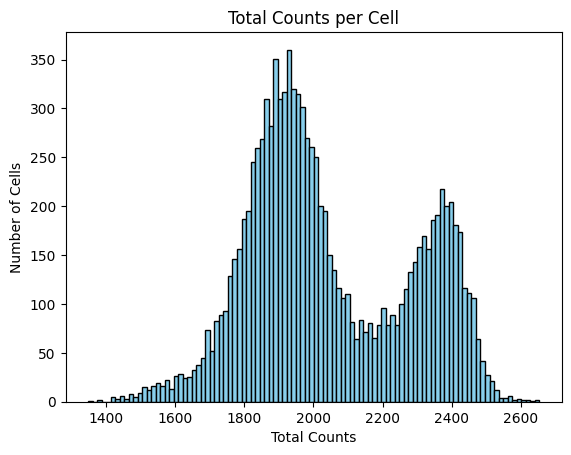

In [10]:
# Plot a histogram of total counts
plt.hist(matrix.obs['total_counts'], bins=100, color='skyblue', edgecolor='black')
plt.title('Total Counts per Cell')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')
plt.show()

There seems to be a noise peak in the above plot below the value of 1400 total counts. 

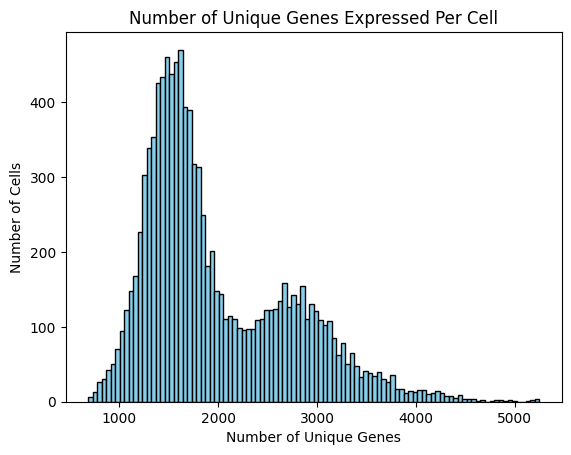

In [11]:
# Plot a histogram of number of genes per barcode
plt.hist(matrix.obs['n_genes_by_counts'], bins=100, color='skyblue', edgecolor='black')
plt.title('Number of Unique Genes Expressed Per Cell')
plt.xlabel('Number of Unique Genes')
plt.ylabel('Number of Cells')
plt.show()

In this graph there is no apparent noise peak on the lower end. 

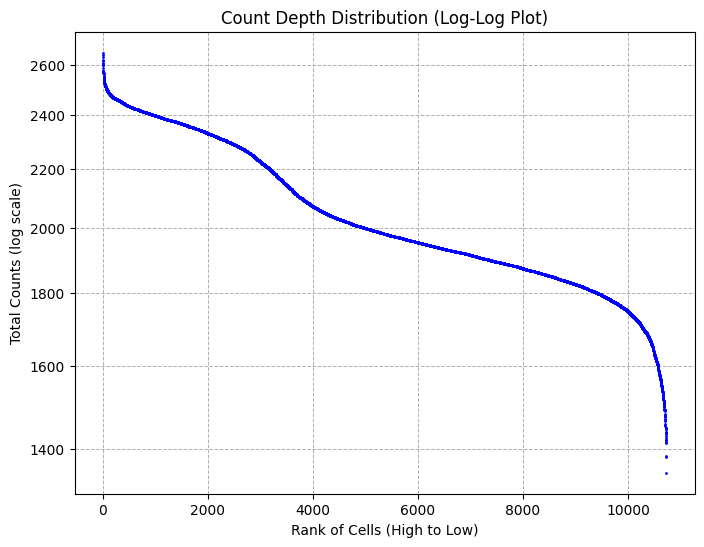

In [12]:
TotalCounts = matrix.obs['total_counts'].values
sorted_counts = np.sort(TotalCounts)[::-1]
ranks = np.arange(1, len(sorted_counts) + 1)
plt.figure(figsize=(8, 6))
plt.plot(ranks, sorted_counts, marker='o', linestyle='none', color='blue', markersize=1)
plt.yscale('log')
plt.xlabel('Rank of Cells (High to Low)')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs='auto'))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_major_formatter(ticker.LogFormatter(base=10.0))
plt.ylabel('Total Counts (log scale)')
plt.title('Count Depth Distribution (Log-Log Plot)')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.show()

In the above graph, the "Elbow" is around 1600 total counts.

Considerations while choosing the threshold - 
- Here, 1400 is chosen as the minimum threshold for total counts. This is because of the noise peak observed on the histogram. 
- While the log graph suggests a total count cutoff at 1600, 1400 is chosen so as to be more permissive (to minimize loss of relevant biological data)
- Further, it is important to consider all the covariates together. The choice of 1400 seems apt even when visualizing the scatter plot of number of unique genes vs. total counts. 
- Additionally, a few highly permissive cutoffs have been included to filter cells by minimum number of unique genes as well as genes by minimum number of cells they are expressed in. 

In [13]:
#Choosing 1400 as the minimum threshold for total counts.
min_counts = 1400 

#Applying the filter
sc.pp.filter_cells(matrix, min_counts=min_counts)

#Adding very permissive thresholds for number of unique genes. 
sc.pp.filter_cells(matrix, min_genes=100)
sc.pp.filter_genes(matrix, min_cells=3)

### Doublet Detection
Making use of Scrublet - the nearest neighbour based doublet detection algorithm.

In [15]:
sc.pp.scrublet(matrix)

In [21]:
np.sum(matrix.obs['predicted_doublet'])

140

Hence, 140 cells have been predicted as doublets. Filtering them out - 

In [22]:
matrix_filtered = matrix[matrix.obs['predicted_doublet']==False, :]
matrix_filtered

View of AnnData object with n_obs × n_vars = 10584 × 12228
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

### Normalization


In [23]:
#Saving the raw counts
matrix_filtered.layers["counts"] = matrix_filtered.X.copy()

C:\Users\Advaith Kannan\AppData\Local\Temp\ipykernel_29752\3718665383.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  matrix_filtered.layers["counts"] = matrix_filtered.X.copy()


In [24]:
# Normalizing to median total counts and transforming it to log(1+x)
sc.pp.normalize_total(matrix_filtered)
sc.pp.log1p(matrix_filtered)

### Feature Selection
This step is to reduce the dimensions of the matrix such that only the most informative genes are retained. Scanpy automatically annotates the highly variable genes.    

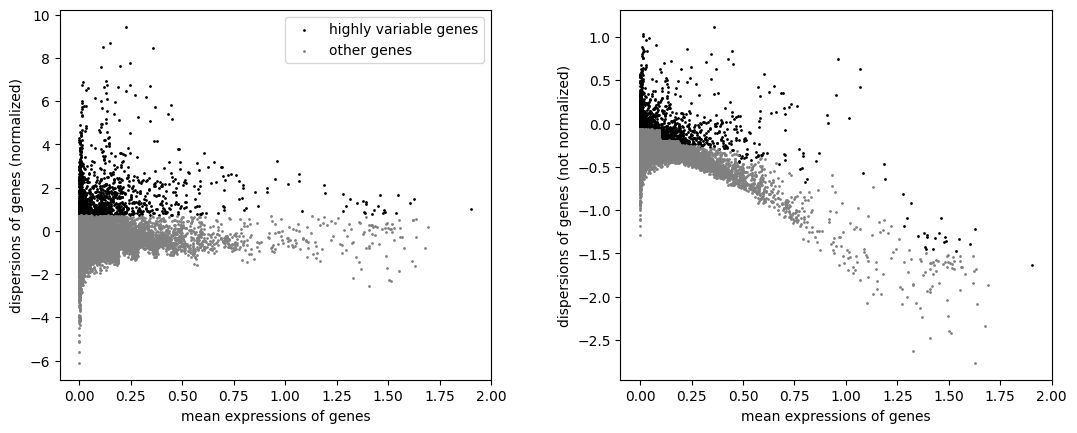

In [26]:
sc.pp.highly_variable_genes(matrix_filtered, n_top_genes=2000)
sc.pl.highly_variable_genes(matrix_filtered)